## Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
import time

## Define Hyperparameters and Constants

In [ ]:
# System and hardware
workers = 4 # Number of worker threads for dataloader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset and Image Parameters
DATA_DIR = '/home/cse/Desktop/Apurbo/datasets/CelebA'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 256

# Model and Training Parameters
LATENT_DIM = 100
EPOCHS = 50
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5

Using device: cuda:0


## Load and Preprocess the Dataset

In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root=DATA_DIR,
                           transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=workers)

## Build the Generator and Discriminator

In [ ]:
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. (512) x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. (256) x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. (128) x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (64) x 32 x 32
            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (128) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (256) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (512) x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the models, move to GPU, and initialize weights
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Define Loss Functions and Optimizers

In [ ]:
# Loss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))

## The Training Loop

In [ ]:
# Create a directory to save generated images
if not os.path.exists('gan_images_pytorch'):
    os.makedirs('gan_images_pytorch')

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCHS):
    start_time = time.time()
    for i, data in enumerate(dataloader, 0):

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, LATENT_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1) # Use .detach() to avoid gradients flowing back to G
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

    # After each epoch, save a sample of generated images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    vutils.save_image(img_list[-1], f"gan_images_pytorch/epoch_{epoch+1}.png")

    print(f'Time for epoch {epoch+1} is {time.time()-start_time:.2f} sec | Loss_D: {errD.item():.4f} | Loss_G: {errG.item():.4f}')

Starting Training Loop...
Time for epoch 1 is 100.53 sec | Loss_D: 0.7191 | Loss_G: 3.5045
Time for epoch 2 is 104.34 sec | Loss_D: 0.5003 | Loss_G: 4.8183
Time for epoch 3 is 105.06 sec | Loss_D: 0.6673 | Loss_G: 3.3014
Time for epoch 4 is 105.13 sec | Loss_D: 0.4113 | Loss_G: 3.2810
Time for epoch 5 is 104.87 sec | Loss_D: 0.6385 | Loss_G: 2.3535
Time for epoch 6 is 105.25 sec | Loss_D: 0.7102 | Loss_G: 2.1090
Time for epoch 7 is 105.30 sec | Loss_D: 1.5049 | Loss_G: 5.6720
Time for epoch 8 is 105.01 sec | Loss_D: 1.3039 | Loss_G: 0.9275
Time for epoch 9 is 105.06 sec | Loss_D: 0.8958 | Loss_G: 3.2353
Time for epoch 10 is 105.45 sec | Loss_D: 0.5472 | Loss_G: 2.8579
Time for epoch 11 is 105.67 sec | Loss_D: 0.6576 | Loss_G: 2.4143
Time for epoch 12 is 105.01 sec | Loss_D: 0.6795 | Loss_G: 3.7218
Time for epoch 13 is 104.78 sec | Loss_D: 0.9496 | Loss_G: 1.0079
Time for epoch 14 is 105.41 sec | Loss_D: 0.6473 | Loss_G: 1.4190
Time for epoch 15 is 105.45 sec | Loss_D: 0.6491 | Loss_G: 

In [ ]:
# Define the filenames for your saved models
DCGAN_GENERATOR_PATH = 'dcgan_generator.pth'
DCGAN_DISCRIMINATOR_PATH = 'dcgan_discriminator.pth'

# Save the state dictionary of the Generator
# The state_dict contains all the learned weights and biases.
torch.save(netG.state_dict(), DCGAN_GENERATOR_PATH)

# Save the state dictionary of the Discriminator
torch.save(netD.state_dict(), DCGAN_DISCRIMINATOR_PATH)

print(f"Task 1 models saved successfully!")
print(f"Generator weights saved to: {DCGAN_GENERATOR_PATH}")
print(f"Discriminator weights saved to: {DCGAN_DISCRIMINATOR_PATH}")

Task 1 models saved successfully!
Generator weights saved to: dcgan_generator.pth
Discriminator weights saved to: dcgan_discriminator.pth


## Visualize Results

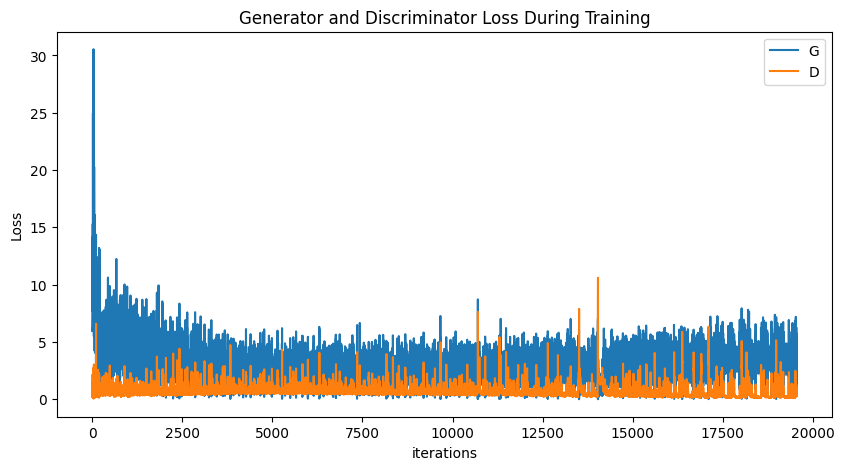

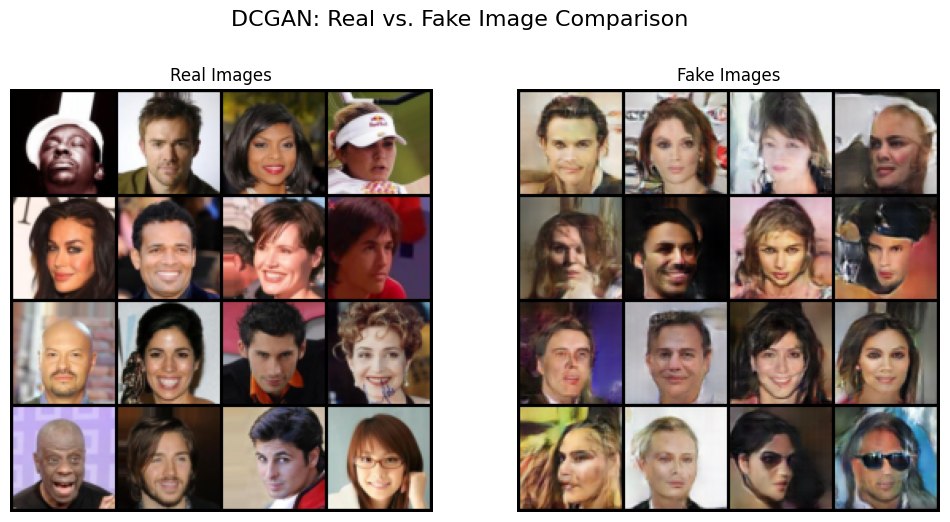

In [ ]:
# ==========================================================
# --- CORRECTED VISUALIZATION CELL for DCGAN ---
# ==========================================================

# --- Part 1: Plotting the Training Losses (No Changes Needed) ---
# Check if G_losses and D_losses exist before plotting
if 'G_losses' in locals() and 'D_losses' in locals():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
else:
    print("Loss history not found in the current session. Skipping loss plot.")


# --- Part 2: Visualizing a 4x4 Grid of Real vs. Fake Images ---

# Grab a fresh batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Generate a new batch of 16 fake images for a clean comparison
# This is more reliable than using the `img_list` from the training loop.
with torch.no_grad():
    # Create 16 random noise vectors
    noise = torch.randn(16, LATENT_DIM, 1, 1, device=device)
    # Pass them through the trained generator
    fake_images = netG(noise).detach().cpu()


# --- Create the side-by-side plot ---
plt.figure(figsize=(12, 6))
plt.suptitle("DCGAN: Real vs. Fake Image Comparison", fontsize=16)

# Plot the real images in a 4x4 grid
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
# MODIFICATION: Slice the batch to get 16 images and set nrow=4
real_grid = vutils.make_grid(real_batch[0][:16], nrow=4, padding=2, normalize=True)
plt.imshow(np.transpose(real_grid, (1, 2, 0)))

# Plot the fake images in a 4x4 grid
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
# MODIFICATION: Use our newly generated 16 images and set nrow=4
fake_grid = vutils.make_grid(fake_images, nrow=4, padding=2, normalize=True)
plt.imshow(np.transpose(fake_grid, (1, 2, 0)))

plt.show()

## Imports and Hyperparameters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# --- Hyperparameters ---

# System and hardware
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
workers = 4 # Number of parallel workers for data loading

# Dataset and Image Parameters
DATA_DIR = '/home/cse/Desktop/Apurbo/datasets/CelebA'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 256 # Adjust if needed based on your GPU memory

# Model and Training Parameters
LATENT_DIM = 100
EPOCHS = 50 # Set the number of epochs for training
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5

# Specific hyperparameters for Conditional GAN
NUM_CLASSES = 2  # 0 for 'not long hair', 1 for 'long hair'
LABEL_EMBEDDING_DIM = 50 # Size of the learnable embedding for the label

Using device: cuda:0


## Custom Labeled Dataset

In [ ]:
class LongHairCelebADataset(Dataset):
    """
    Custom Dataset for CelebA.
    Defines 'long hair' (label 1) as having 'Blond_Hair' OR 'Wavy_Hair'.
    All other images are 'not long hair' (label 0).
    """
    def __init__(self, img_dir, attr_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Read the attribute file using pandas
        self.attr = pd.read_csv(attr_file, delim_whitespace=True, header=1)

        # --- Define our custom 'long hair' label ---
        # 1. Get the relevant columns, converting -1 to 0 and 1 to 1.
        # blond = self.attr['Blond_Hair'].replace(-1, 0)
        # wavy = self.attr['Blond_Hair'].replace(-1, 0)

        # 2. Apply the OR logic. The result will be 1 if either is 1, else 0.
        # The | operator is a bitwise OR, which works perfectly here.
        # long_hair_label = (blond | wavy)
        long_hair_label = self.attr['Blond_Hair'].replace(-1, 0)

        # 3. Store the final labels and image names
        self.labels = long_hair_label.values
        self.img_names = self.attr.index.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# --- Create the DataLoader using our custom Dataset ---
img_dir_path = os.path.join(DATA_DIR, 'img_align_celeba')
attr_file_path = os.path.join(DATA_DIR, 'list_attr_celeba.txt')

transformations = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

celeba_dataset = LongHairCelebADataset(img_dir=img_dir_path, attr_file=attr_file_path, transform=transformations)
dataloader = DataLoader(celeba_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)

# Optional: Check the balance of our new label
long_hair_count = (celeba_dataset.labels == 1).sum()
short_hair_count = (celeba_dataset.labels == 0).sum()
print(f"Dataset loaded. Found {len(celeba_dataset)} images.")
print(f"Number of images with 'Long Hair' (label 1): {long_hair_count}")
print(f"Number of images with 'Not Long Hair' (label 0): {short_hair_count}")

/tmp/ipykernel_4793/2935285655.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.attr = pd.read_csv(attr_file, delim_whitespace=True, header=1)


Dataset loaded. Found 202599 images.
Number of images with 'Long Hair' (label 1): 29983
Number of images with 'Not Long Hair' (label 0): 172616


## Conditional Generator and Discriminator Models

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(NUM_CLASSES, LABEL_EMBEDDING_DIM)
        input_dim = LATENT_DIM + LABEL_EMBEDDING_DIM

        self.main = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_emb = self.label_embedding(labels).view(labels.size(0), LABEL_EMBEDDING_DIM, 1, 1)
        gen_input = torch.cat((noise, label_emb), 1)
        return self.main(gen_input)

# ==========================================================
# --- NEW, MORE STABLE CONDITIONAL DISCRIMINATOR ---
# ==========================================================

class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()

        # This is the main convolutional path for the image
        self.image_path = nn.Sequential(
            # Input is (CHANNELS) x 64 x 64
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (128) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (256) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (512) x 4 x 4
        )

        # This is the separate path for the label
        self.label_path = nn.Sequential(
            # We use a smaller embedding dimension here
            nn.Embedding(NUM_CLASSES, 50),
            nn.Linear(50, 512 * 4 * 4) # Project it to match the image feature size
        )

        # This is the final classifier path after concatenation
        self.classifier = nn.Sequential(
            # The input size is now doubled because we concatenate image and label features
            nn.Conv2d(512 * 2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image, labels):
        # 1. Process the image to get image features
        image_features = self.image_path(image)

        # 2. Process the label to get label features
        # We need to reshape the label features to match the image feature dimensions
        label_features = self.label_path(labels).view(-1, 512, 4, 4)

        # 3. Concatenate the features along the channel dimension
        combined_features = torch.cat([image_features, label_features], dim=1)

        # 4. Pass the combined features through the final classifier
        output = self.classifier(combined_features)

        return output

netG = ConditionalGenerator().to(device)
netD = ConditionalDiscriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)
print("Generator and Discriminator models created successfully.")

Generator and Discriminator models created successfully.


## The Training Loop

In [ ]:
def train_cgan(dataloader, epochs):
    # Setup for training
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))

    # Lists to keep track of progress
    G_losses = []
    D_losses = []

    # Create a directory for saving images if it doesn't exist
    output_dir = 'cgan_longhair_images'
    os.makedirs(output_dir, exist_ok=True)

    print("Starting Conditional GAN Training...")
    for epoch in range(epochs):
        start_time = time.time()
        for i, (real_images, real_labels) in enumerate(dataloader, 0):
            real_images = real_images.to(device)
            real_labels = real_labels.to(device).long() # Ensure labels are long type for embedding
            b_size = real_images.size(0)

            # --- (1) Update Discriminator ---
            netD.zero_grad()

            # Train with real images
            label_true = torch.full((b_size,), 1., dtype=torch.float, device=device)
            output = netD(real_images, real_labels).view(-1)
            errD_real = criterion(output, label_true)
            errD_real.backward()

            # Train with fake images
            noise = torch.randn(b_size, LATENT_DIM, 1, 1, device=device)
            fake_labels = torch.randint(0, NUM_CLASSES, (b_size,), device=device).long()
            fake_images = netG(noise, fake_labels)

            label_false = torch.full((b_size,), 0., dtype=torch.float, device=device)
            output = netD(fake_images.detach(), fake_labels).view(-1)
            errD_fake = criterion(output, label_false)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            # --- (2) Update Generator ---
            netG.zero_grad()
            output = netD(fake_images, fake_labels).view(-1)
            errG = criterion(output, label_true) # G wants D to think the fake images are real
            errG.backward()
            optimizerG.step()

            # Save losses for plotting
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        print(f'Epoch [{epoch+1}/{epochs}] | Loss_D: {errD.item():.4f} | Loss_G: {errG.item():.4f} | Time: {time.time()-start_time:.2f}s')

        # After each epoch, save generated images for inspection
        with torch.no_grad():
            fixed_noise = torch.randn(16, LATENT_DIM, 1, 1, device=device)
            labels_long = torch.full((16,), 1, dtype=torch.long, device=device)
            fake_long_hair_grid = netG(fixed_noise, labels_long).detach().cpu()
            vutils.save_image(fake_long_hair_grid, f"{output_dir}/epoch_{epoch+1}.png", normalize=True)

    return G_losses, D_losses

# --- Main execution block to start training ---
if __name__ == '__main__':
    G_losses, D_losses = train_cgan(dataloader, EPOCHS)

    # Save the final models
    torch.save(netG.state_dict(), 'cgan_longhair_generator.pth')
    torch.save(netD.state_dict(), 'cgan_longhair_discriminator.pth')
    print("\nTraining complete. Models saved.")

Starting Conditional GAN Training...


Epoch [1/50] | Loss_D: 0.3512 | Loss_G: 4.0286 | Time: 2256.98s
Epoch [2/50] | Loss_D: 0.5128 | Loss_G: 3.8153 | Time: 215.68s
Epoch [3/50] | Loss_D: 0.3038 | Loss_G: 2.8924 | Time: 219.92s
Epoch [4/50] | Loss_D: 0.3372 | Loss_G: 6.4303 | Time: 222.17s
Epoch [5/50] | Loss_D: 0.6648 | Loss_G: 7.9046 | Time: 222.09s
Epoch [6/50] | Loss_D: 0.2865 | Loss_G: 5.1702 | Time: 222.63s
Epoch [7/50] | Loss_D: 0.7052 | Loss_G: 9.2427 | Time: 222.67s
Epoch [8/50] | Loss_D: 0.3182 | Loss_G: 3.3182 | Time: 222.03s
Epoch [9/50] | Loss_D: 0.3275 | Loss_G: 9.8311 | Time: 222.15s
Epoch [10/50] | Loss_D: 0.1759 | Loss_G: 5.2076 | Time: 222.43s
Epoch [11/50] | Loss_D: 1.0878 | Loss_G: 6.2842 | Time: 222.61s
Epoch [12/50] | Loss_D: 0.2566 | Loss_G: 5.6169 | Time: 222.28s
Epoch [13/50] | Loss_D: 0.2801 | Loss_G: 7.2051 | Time: 222.68s
Epoch [14/50] | Loss_D: 0.1528 | Loss_G: 5.1237 | Time: 222.86s
Epoch [15/50] | Loss_D: 0.5084 | Loss_G: 3.5554 | Time: 223.05s
Epoch [16/50] | Loss_D: 0.3989 | Loss_G: 10.4659

## Visualization of Results

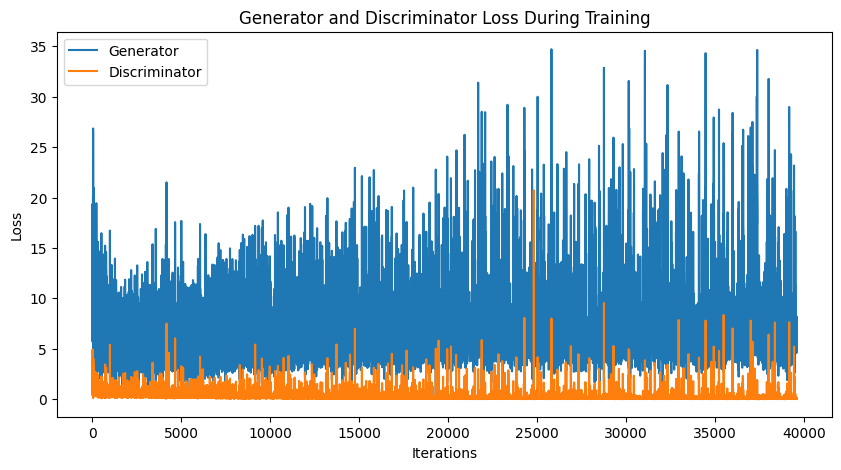


Visualizing with the generator model currently in memory.
Searching for 16 real 'long hair' images from the dataset...
Generating 16 fake 'long hair' images...


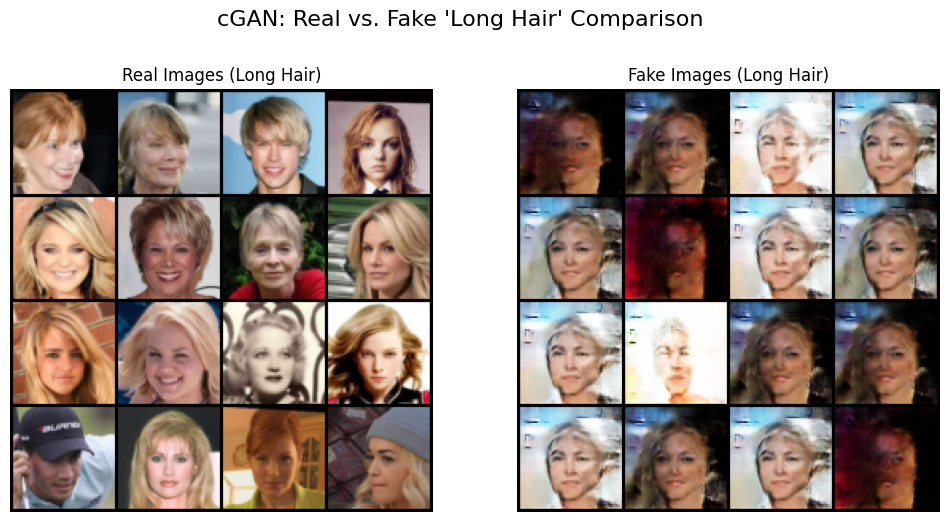

In [ ]:
# ==========================================================
# --- CORRECTED VISUALIZATION CELL for cGAN ---
# ==========================================================

# --- Part 1: Plotting the Training Losses (No Changes Needed) ---
# It's good practice to check if the loss lists exist before plotting
if 'G_losses' in locals() and 'D_losses' in locals():
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
else:
    print("Loss history not found in the current session. Skipping loss plot.")


# --- Part 2: Visualizing Real vs. Fake 'Long Hair' Images ---

# Load the trained generator if you are in a new session
# Ensure the model is in evaluation mode
try:
    netG.eval()
    print("\nVisualizing with the generator model currently in memory.")
except NameError:
    print("\nGenerator 'netG' not found. Loading from file...")
    netG = ConditionalGenerator().to(device)
    netG.load_state_dict(torch.load('cgan_longhair_generator.pth'))
    netG.eval() # Set to evaluation mode

# --- Step A: Find 16 REAL images with the 'long hair' label (label 1) ---
print("Searching for 16 real 'long hair' images from the dataset...")
real_long_hair_images = []
num_needed = 16
# Iterate through the dataloader to find them
for images, labels in dataloader:
    # Find images in the current batch with the correct label
    long_hair_in_batch = images[labels == 1]
    real_long_hair_images.append(long_hair_in_batch)

    # Check if we have enough
    if sum([len(b) for b in real_long_hair_images]) >= num_needed:
        break
# Concatenate the collected tensors and slice to get exactly 16
real_long_hair_tensor = torch.cat(real_long_hair_images)[:num_needed]


# --- Step B: Generate 16 FAKE images with the 'long hair' label (label 1) ---
print("Generating 16 fake 'long hair' images...")
with torch.no_grad():
    # Create 16 noise vectors
    noise = torch.randn(num_needed, LATENT_DIM, 1, 1, device=device)
    # Create 16 'long hair' labels
    long_hair_labels = torch.full((num_needed,), 1, dtype=torch.long, device=device)
    # Generate the fake images
    fake_long_hair_images = netG(noise, long_hair_labels).detach().cpu()


# --- Step C: Create the side-by-side plot ---
plt.figure(figsize=(12, 6))
plt.suptitle("cGAN: Real vs. Fake 'Long Hair' Comparison", fontsize=16)

# Plot the real images in a 4x4 grid
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images (Long Hair)")
# MODIFICATION: Use our collected real images and set nrow=4
real_grid = vutils.make_grid(real_long_hair_tensor, nrow=4, padding=2, normalize=True)
plt.imshow(np.transpose(real_grid, (1, 2, 0)))

# Plot the fake images in a 4x4 grid
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images (Long Hair)")
# MODIFICATION: Use our generated fake images and set nrow=4
fake_grid = vutils.make_grid(fake_long_hair_images, nrow=4, padding=2, normalize=True)
plt.imshow(np.transpose(fake_grid, (1, 2, 0)))

plt.show()

In [ ]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# --- Hyperparameters ---

# System and hardware
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
workers = 4

# Dataset and Image Parameters
# This is the root directory containing trainA and trainB
DATA_ROOT = '/home/cse/Desktop/Apurbo/datasets/cycleGAN/horse2zebra/horse2zebra'
IMAGE_SIZE = 128 # CycleGANs often work better with slightly larger images
CHANNELS = 3
# CycleGANs are memory intensive, so we start with a batch size of 1
BATCH_SIZE = 256

# Model and Training Parameters
EPOCHS = 50 # CycleGANs require long training times
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
DECAY_START_EPOCH = 10 # Epoch to start linearly decaying the learning rate

# Loss Weights
LAMBDA_CYCLE = 10.0      # Weight for cycle consistency loss
LAMBDA_IDENTITY = 5.0   # Weight for identity loss

Using device: cuda:0


In [ ]:
class ImageDataset(Dataset):
    """
    Custom Dataset for handling two unpaired image domains (A and B).
    """
    def __init__(self, root, transform=None, unaligned=True):
        self.transform = transform
        self.unaligned = unaligned

        # Find all image file paths in trainA and trainB folders
        self.files_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*.*'))

        print(f"Found {len(self.files_A)} images in trainA and {len(self.files_B)} images in trainB.")

    def __getitem__(self, index):
        # Load image from Domain A
        image_A = Image.open(self.files_A[index % len(self.files_A)]).convert('RGB')

        # Load a corresponding image from Domain B
        if self.unaligned:
            # For unpaired data, pick a random image from Domain B
            index_B = random.randint(0, len(self.files_B) - 1)
        else:
            # For paired data, use the same index
            index_B = index % len(self.files_B)
        image_B = Image.open(self.files_B[index_B]).convert('RGB')

        # Apply transformations
        if self.transform:
            item_A = self.transform(image_A)
            item_B = self.transform(image_B)

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        # Use the length of the larger dataset to ensure we see all images
        return max(len(self.files_A), len(self.files_B))

# --- Create the DataLoader using our custom Dataset ---

# Define transformations, including data augmentation
transformations = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE * 1.12), Image.BICUBIC),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Instantiate the dataset and dataloader
cyclegan_dataset = ImageDataset(root=DATA_ROOT, transform=transformations)
dataloader = DataLoader(cyclegan_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)

print(f"Dataset and DataLoader created successfully.")

Found 5000 images in trainA and 281 images in trainB.
Dataset and DataLoader created successfully.


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# --- Generator Architecture ---
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )
    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        channels = input_shape[0]
        # Initial convolution block
        out_features = 64
        model = [nn.ReflectionPad2d(channels),
                 nn.Conv2d(channels, out_features, 7),
                 nn.InstanceNorm2d(out_features),
                 nn.ReLU(inplace=True)]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [nn.Upsample(scale_factor=2),
                      nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
        # Output layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# --- Discriminator Architecture (PatchGAN) ---
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        channels, height, width = input_shape
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2**4, width // 2**4)
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
    def forward(self, img):
        return self.model(img)

# --- Initialize models ---
input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
G_AtoB = GeneratorResNet(input_shape).to(device)
G_BtoA = GeneratorResNet(input_shape).to(device)
D_A = Discriminator(input_shape).to(device)
D_B = Discriminator(input_shape).to(device)

G_AtoB.apply(weights_init)
G_BtoA.apply(weights_init)
D_A.apply(weights_init)
D_B.apply(weights_init)

print("CycleGAN models created successfully.")

CycleGAN models created successfully.


In [ ]:
# --- Loss Functions ---
# Adversarial Loss (how well the generator fools the discriminator)
# We use MSELoss as it's more stable than BCELoss for CycleGAN
criterion_GAN = torch.nn.MSELoss().to(device)
# Cycle Consistency Loss (how well the reconstructed image matches the original)
criterion_cycle = torch.nn.L1Loss().to(device)
# Identity Loss (how well the generator preserves the image when it's already in the target domain)
criterion_identity = torch.nn.L1Loss().to(device)

# --- Optimizers ---
import itertools
# We need three separate optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_AtoB.parameters(), G_BtoA.parameters()), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, 0.999))

# --- Learning Rate Scheduler ---
# This will linearly decay the learning rate to 0 over the last 100 epochs
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before training ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

# Create schedulers for all three optimizers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(EPOCHS, 0, DECAY_START_EPOCH).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(EPOCHS, 0, DECAY_START_EPOCH).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(EPOCHS, 0, DECAY_START_EPOCH).step)

# --- Replay Buffer (Image Buffer) ---
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer."
        self.max_size = max_size
        self.data = []
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

# Create buffers for fake images of domain A and B
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

print("Training utilities, optimizers, and schedulers initialized.")

Training utilities, optimizers, and schedulers initialized.


In [ ]:
# --- Main Training Loop ---
if __name__ == '__main__':
    # Create directories for saving results
    output_dir_samples = 'cyclegan_samples'
    output_dir_models = 'cyclegan_models'
    os.makedirs(output_dir_samples, exist_ok=True)
    os.makedirs(output_dir_models, exist_ok=True)

    print("Starting CycleGAN Training...")

    for epoch in range(EPOCHS):
        start_time = time.time()
        for i, batch in enumerate(dataloader):
            # Set model input
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)

            # Adversarial ground truths
            # The target for a "real" image is a tensor of 1s
            # The target for a "fake" image is a tensor of 0s
            # The size matches the output of our PatchGAN discriminator
            target_real = torch.ones((real_A.size(0), *D_A.output_shape), requires_grad=False).to(device)
            target_fake = torch.zeros((real_A.size(0), *D_A.output_shape), requires_grad=False).to(device)

            # ------------------
            #  Train Generators
            # ------------------
            G_AtoB.train()
            G_BtoA.train()
            optimizer_G.zero_grad()

            # Identity loss
            loss_id_A = criterion_identity(G_BtoA(real_A), real_A)
            loss_id_B = criterion_identity(G_AtoB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN loss
            fake_B = G_AtoB(real_A)
            loss_GAN_AtoB = criterion_GAN(D_B(fake_B), target_real)
            fake_A = G_BtoA(real_B)
            loss_GAN_BtoA = criterion_GAN(D_A(fake_A), target_real)
            loss_GAN = (loss_GAN_AtoB + loss_GAN_BtoA) / 2

            # Cycle loss
            reconstructed_A = G_BtoA(fake_B)
            loss_cycle_A = criterion_cycle(reconstructed_A, real_A)
            reconstructed_B = G_AtoB(fake_A)
            loss_cycle_B = criterion_cycle(reconstructed_B, real_B)
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total generator loss
            loss_G = loss_GAN + LAMBDA_CYCLE * loss_cycle + LAMBDA_IDENTITY * loss_identity
            loss_G.backward()
            optimizer_G.step()

            # -----------------------
            #  Train Discriminator A
            # -----------------------
            optimizer_D_A.zero_grad()
            # Real loss
            loss_real = criterion_GAN(D_A(real_A), target_real)
            # Fake loss
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(D_A(fake_A_.detach()), target_fake)
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2
            loss_D_A.backward()
            optimizer_D_A.step()

            # -----------------------
            #  Train Discriminator B
            # -----------------------
            optimizer_D_B.zero_grad()
            # Real loss
            loss_real = criterion_GAN(D_B(real_B), target_real)
            # Fake loss
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()), target_fake)
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2
            loss_D_B.backward()
            optimizer_D_B.step()

        # --- End of Epoch ---
        epoch_time = time.time() - start_time
        loss_D = (loss_D_A + loss_D_B) / 2
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f} | Time: {epoch_time:.2f}s")

        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

        # --- Save a sample of generated images ---
        # Take the first image from the last batch
        sample_real_A = real_A[0].unsqueeze(0)
        sample_fake_B = G_AtoB(sample_real_A).detach()
        sample_real_B = real_B[0].unsqueeze(0)
        sample_fake_A = G_BtoA(sample_real_B).detach()
        # Arrange them in a grid
        image_grid = torch.cat((sample_real_A, sample_fake_B, sample_real_B, sample_fake_A), 0)
        vutils.save_image(image_grid, f"{output_dir_samples}/epoch_{epoch+1}.png", nrow=4, normalize=True)

        # --- Save model checkpoints ---
        torch.save(G_AtoB.state_dict(), f"{output_dir_models}/G_AtoB.pth")
        torch.save(G_BtoA.state_dict(), f"{output_dir_models}/G_BtoA.pth")
        torch.save(D_A.state_dict(), f"{output_dir_models}/D_A.pth")
        torch.save(D_B.state_dict(), f"{output_dir_models}/D_B.pth")

Starting CycleGAN Training...


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 7.91 GiB total capacity; 5.60 GiB already allocated; 286.94 MiB free; 5.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

Successfully loaded weights from 'cyclegan_models/G_AtoB.pth'
Fetching 16 real face photos from the dataset...
Translating photos to the painted domain...
Plotting results...


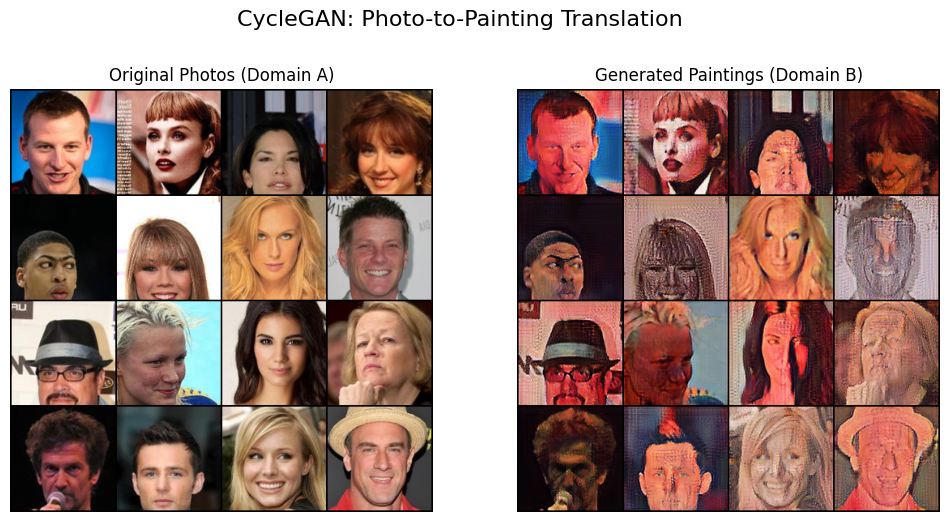

In [ ]:
GENERATOR_A_TO_B_PATH = 'cyclegan_models/G_AtoB.pth'

# Define the input shape to instantiate the model class
input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)

# Instantiate the generator
G_AtoB = GeneratorResNet(input_shape).to(device)

try:
    # Load the learned weights from the file
    G_AtoB.load_state_dict(torch.load(GENERATOR_A_TO_B_PATH))
    print(f"Successfully loaded weights from '{GENERATOR_A_TO_B_PATH}'")
except FileNotFoundError:
    print(f"Error: Model file not found at '{GENERATOR_A_TO_B_PATH}'.")
    print("Please make sure you have trained the model and the file exists.")
    # Exit or handle the error appropriately if the model isn't found

# Set the model to evaluation mode. This is crucial for getting correct results.
G_AtoB.eval()


# --- Step 3: Get 16 Real Face Photos (Domain A) ---
print("Fetching 16 real face photos from the dataset...")
try:
    # We will iterate through the dataloader to collect 16 images,
    # which is robust even if your batch size is small.
    real_photos_list = []
    num_needed = 16
    for i, batch in enumerate(dataloader):
        # Add the 'A' images from the batch to our list
        real_photos_list.append(batch['A'])
        # Check if we have collected enough images
        if sum([b.size(0) for b in real_photos_list]) >= num_needed:
            break

    # Concatenate the list of tensors into a single batch and slice to get exactly 16
    real_photos = torch.cat(real_photos_list, 0)[:num_needed].to(device)

except NameError:
    print("Error: `dataloader` not found. Please run the data loading cell from your script first.")


# --- Step 4: Generate the Painted Versions ---
print("Translating photos to the painted domain...")
# Use torch.no_grad() to disable gradient calculations, saving memory and speeding up inference
with torch.no_grad():
    fake_paintings = G_AtoB(real_photos).detach().cpu()


# --- Step 5: Plot the Side-by-Side Comparison ---
print("Plotting results...")
plt.figure(figsize=(12, 6))
plt.suptitle("CycleGAN: Photo-to-Painting Translation", fontsize=16)

# Plot the original real photos
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Original Photos (Domain A)")
# Use make_grid with nrow=4 for a 4x4 layout
real_grid = vutils.make_grid(real_photos.cpu(), nrow=4, padding=2, normalize=True)
plt.imshow(np.transpose(real_grid, (1, 2, 0)))

# Plot the generated painted images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Generated Paintings (Domain B)")
# Use make_grid with nrow=4 for a 4x4 layout
fake_grid = vutils.make_grid(fake_paintings, nrow=4, padding=2, normalize=True)
plt.imshow(np.transpose(fake_grid, (1, 2, 0)))

plt.show()

Successfully loaded weights from 'cyclegan_models/G_AtoB.pth'
Fetching 8 real face photos from the dataset...
Translating photos to the painted domain...
Plotting results...


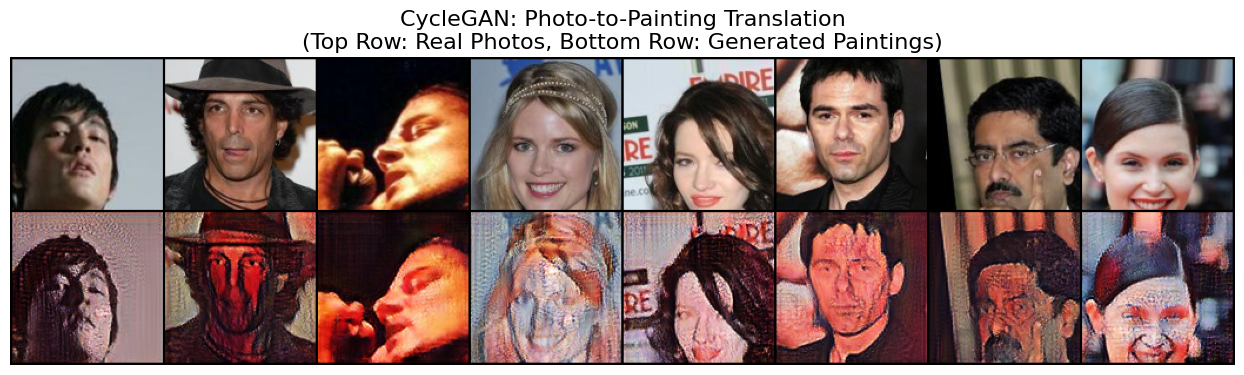

In [ ]:
# ==========================================================
# --- CycleGAN: Final Visualization (Top/Bottom Comparison) ---
# ==========================================================

# --- Step 1: Load the Trained Generator (G_AtoB) ---

# Define the path to your saved model
GENERATOR_A_TO_B_PATH = 'cyclegan_models/G_AtoB.pth'
input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
G_AtoB = GeneratorResNet(input_shape).to(device)

try:
    G_AtoB.load_state_dict(torch.load(GENERATOR_A_TO_B_PATH))
    print(f"Successfully loaded weights from '{GENERATOR_A_TO_B_PATH}'")
except FileNotFoundError:
    print(f"Error: Model file not found at '{GENERATOR_A_TO_B_PATH}'.")
    # Handle error...

# Set the model to evaluation mode
G_AtoB.eval()

# --- Step 2: Get 8 Real Face Photos (Domain A) ---
print("Fetching 8 real face photos from the dataset...")
try:
    # MODIFICATION: Change number of images needed to 8
    num_needed = 8
    real_photos_list = []
    for i, batch in enumerate(dataloader):
        real_photos_list.append(batch['A'])
        if sum([b.size(0) for b in real_photos_list]) >= num_needed:
            break

    real_photos = torch.cat(real_photos_list, 0)[:num_needed].to(device)

except NameError:
    print("Error: `dataloader` not found. Please run the data loading cell first.")

# --- Step 3: Generate the 8 Painted Versions ---
print("Translating photos to the painted domain...")
with torch.no_grad():
    fake_paintings = G_AtoB(real_photos).detach().cpu()

# --- Step 4: Combine and Plot in a Single Grid ---
print("Plotting results...")

# MODIFICATION: Concatenate real and fake images into one tensor for a single grid
# The first 8 images will be real, the next 8 will be fake.
combined_images = torch.cat([real_photos.cpu(), fake_paintings], dim=0)

# Create a single figure
plt.figure(figsize=(16, 4)) # Adjust figsize for a 2x8 layout
plt.axis("off")
plt.title("CycleGAN: Photo-to-Painting Translation\n(Top Row: Real Photos, Bottom Row: Generated Paintings)", fontsize=16)

# MODIFICATION: Create one grid with 8 images per row.
# This will automatically place the first 8 (real) on top of the next 8 (fake).
image_grid = vutils.make_grid(combined_images, nrow=8, padding=2, normalize=True)
plt.imshow(np.transpose(image_grid, (1, 2, 0)))

plt.show()